In [84]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import precision_recall_curve

print(tf.config.list_physical_devices('GPU'))
from sklearn.metrics import recall_score, f1_score
from keras import backend as K
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import mixed_precision
from datetime import datetime
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
from tensorflow.keras import layers
from tensorflow.keras import regularizers

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import custom_object_scope


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:


# Load the training set from a CSV file
X_train = pd.read_csv('../../data/X_train_balanceado.csv')
y_train = pd.read_csv('../../data/y_train_balanceado.csv')

# Load the test set from a CSV file
X_test = pd.read_csv('../../data/X_test_balanceado.csv')
y_test = pd.read_csv('../../data/y_test_balanceado.csv')

In [3]:
# Check the label distribution of the training set
print('Training set label distribution:')
print(y_train['Label'].value_counts())

# Check the label distribution of the test set
print('Test set label distribution:')
print(y_test['Label'].value_counts())

Training set label distribution:
Label
0    18228
1    18228
Name: count, dtype: int64
Test set label distribution:
Label
1    27278
0     4471
Name: count, dtype: int64


In [4]:


# Create a scaler object
scaler = StandardScaler()

# Fit the scaler to the training data
scaler.fit(X_train)

# Scale the training and test data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [5]:
X_train_scaled.shape

(36456, 777)

In [6]:
y_train = np.array(y_train.values)
y_test = np.array(y_test.values)

In [7]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [52]:
# Define the batch size
batch_size = 64

# Define the number of epochs
epochs = 200

# Define the model ID
model_id = 'dnn_9'

# Define the TensorBoard callback
log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S") + "_" + model_id + f"_bs_{batch_size}_ep_{epochs}"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Define the ModelCheckpoint callback with the model ID in the filename
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=f'model_{model_id}_{{epoch:02d}}-{{val_accuracy:.2f}}.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1)

# Define the EarlyStopping callback
early_stopping_callback = EarlyStopping(monitor='val_accuracy', patience=50)

model = tf.keras.Sequential([
    layers.Dense(512, input_shape=(777,), kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)),
    layers.ReLU(),
    layers.Dropout(0.2),
    layers.Dense(256, kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)),
    layers.ReLU(),
    layers.Dropout(0.2),
    layers.Dense(128, kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)),
    layers.ReLU(),
    layers.Dropout(0.2),
    layers.Dense(64, kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)),
    layers.ReLU(),
    layers.Dropout(0.2),
    layers.Dense(32, kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)),
    layers.ReLU(),
    layers.Dropout(0.2),
    layers.Dense(16, kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)),
    layers.ReLU(),
    layers.Dropout(0.2),
    layers.Dense(8, kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)),
    layers.ReLU(),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

# Define the learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9)

# Define the optimizer with the learning rate schedule
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Compile the model with the new optimizer
model.compile(optimizer=optimizer, loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Recall(), f1_m])





In [53]:
# Fit the model with the new settings and callbacks
model.fit(X_train_scaled, y_train, batch_size=batch_size, epochs=epochs,
          validation_data=(X_test_scaled, y_test),
          callbacks=[tensorboard_callback, checkpoint_callback, early_stopping_callback])

Epoch 1/200
557/570 [============================>.] - ETA: 0s - loss: 14.3969 - accuracy: 0.5038 - recall_23: 0.3963 - f1_m: 0.2752
Epoch 1: val_accuracy improved from -inf to 0.85918, saving model to model_dnn_9_01-0.86.h5
570/570 [==============================] - 5s 6ms/step - loss: 14.1089 - accuracy: 0.5035 - recall_23: 0.4095 - f1_m: 0.2839 - val_loss: 1.3950 - val_accuracy: 0.8592 - val_recall_23: 1.0000 - val_f1_m: 0.9152
Epoch 2/200
559/570 [============================>.] - ETA: 0s - loss: 1.3868 - accuracy: 0.4975 - recall_23: 0.7004 - f1_m: 0.4661
Epoch 2: val_accuracy did not improve from 0.85918
570/570 [==============================] - 3s 5ms/step - loss: 1.3868 - accuracy: 0.4971 - recall_23: 0.7057 - f1_m: 0.4695 - val_loss: 1.3796 - val_accuracy: 0.8592 - val_recall_23: 1.0000 - val_f1_m: 0.9152
Epoch 3/200
570/570 [==============================] - ETA: 0s - loss: 1.3832 - accuracy: 0.5007 - recall_23: 0.3599 - f1_m: 0.2393
Epoch 3: val_accuracy did not improve fro

KeyboardInterrupt: 

In [85]:
# Load the saved model with custom metric function
with custom_object_scope({'f1_m': f1_m}):
    model = load_model('model_dnn_6_02-0.78.h5')

In [86]:
input_shape = model.layers[0].input_shape

In [87]:
input_shape

(None, 777)

In [74]:
# Make predictions on new data
y_pred = model.predict(X_test_scaled)

993/993 [==============================] - 1s 717us/step


In [75]:
y_pred_round = np.round(y_pred)   
y_test = y_test.astype(np.float32)

In [76]:
print(y_pred.dtype)

float32


In [77]:
# Calculate the F1 score
f1 = f1_m(y_test, y_pred)

print('F1 score: ', f1.numpy())

F1 score:  0.867025


In [78]:
# Calculate the Recall 
recall = recall_m(y_test, y_pred_round)
print('Recall: ', recall.numpy())

Recall:  0.8454432


In [79]:
# Calculate accuracy
accuracy = np.sum(y_pred_round == y_test) / len(y_test)
print('Accuracy: ', accuracy)

Accuracy:  0.7771898327506378


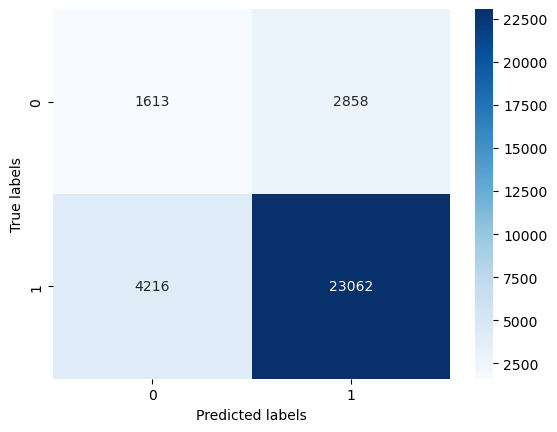

In [80]:


# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_round)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

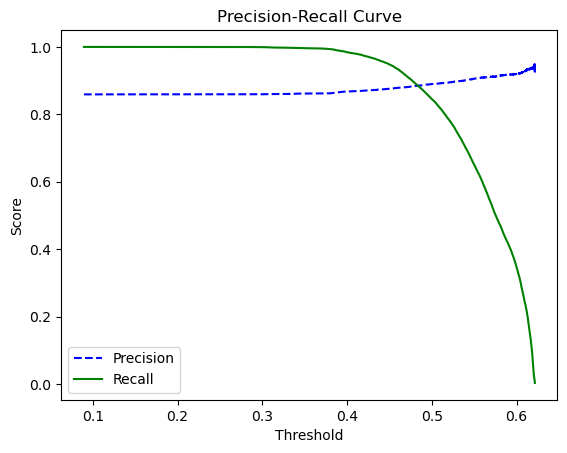

In [81]:
# Calculate the precision and recall at various thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

# Plot the precision-recall curve with threshold values
plt.plot(thresholds, precision[:-1], 'b--', label='Precision')
plt.plot(thresholds, recall[:-1], 'g-', label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend(loc='best')
plt.title('Precision-Recall Curve')
plt.show()

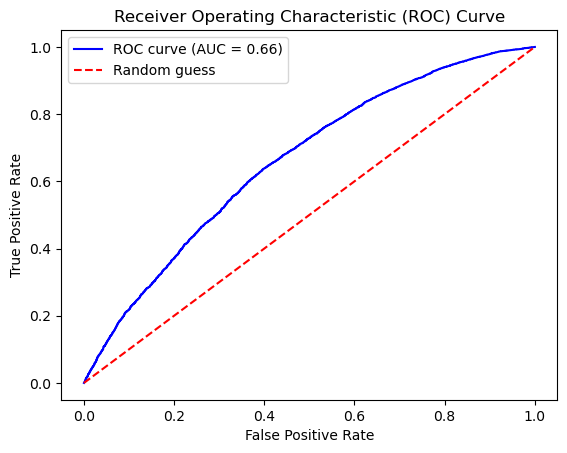

In [82]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calculate the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, 'b-', label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'r--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()

In [83]:
tf.saved_model.save(model, 'Best_model/')

2023-06-22 03:46:17.728772: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-06-22 03:46:17.739769: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-06-22 03:46:17.750648: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-06-22 03:46:

INFO:tensorflow:Assets written to: Best_model/assets


INFO:tensorflow:Assets written to: Best_model/assets
